In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from functions import get_zone, load_360_data, get_progressive_actions, zone_polygon, plot_team_zone_shares, calc_width, calc_directness
import seaborn as sns

### Features to use

Main tactical features to use:
- Width offensivly ✅
Average distance from center-line (goal-to-goal) where progressive actions end. 
- Directness ✅
Relationship of progressive actions to non progressive actions
- Tempo
Velocity of ball, how fast do actions happen?
- Pass length

- Restförsvar ?
- Fasta situationer ?
- Press, triggers (defensiva aktioner i offensiv planhalva) (tid för bollvinst)
- Höjd på backlinje
- Antal progressiva passningar

- Bollhastighet
- Final third entries

### Game State:
- Which zone are we in?
- Distance to goal?
- Angle to goal?
- Opponents near?
- How many opponants near?
- Score?
-  Red cards?

### Tactics: 


In [2]:
actions=("Pass", "Carry", "Dribble")
action_types_exclude = ["Throw-in", "Corner", "Free Kick", "Kick-off", "Goal Kick"]
df = load_360_data(actions, three_sixty_only=False)

print("data loaded")

#is_dead_ball_action = df["pass_type"].isin(action_types_exclude)


actions = get_progressive_actions(df=df)
prog_passes = actions[actions["is_progressive"] == True]



Loading events: 100%|██████████| 3464/3464 [02:59<00:00, 19.34it/s]


data loaded


In [3]:

###NEW
import numpy as np
import pandas as pd

def calc_possession_time(df, match=True):
    """
    Possession time (seconds) per team, computed from StatsBomb possession segments.

    Required columns:
      - match_id
      - possession
      - timestamp   (string like '00:00:06.293')
      - duration    (seconds; may be missing -> treated as 0)
      - possession_team_id  (recommended)
        OR possession_team (object) if you still have nested dicts

    Notes:
      - Uses millisecond 'timestamp' rather than minute/second.
      - Duration is added to the final event in a possession to avoid undercounting.
    """
    df = df.copy()

    # enforce integer IDs early
    for c in ["match_id"]:
        if c in df.columns:
            df[c] = df[c].astype("Int64")

    # If you don't already have possession_team_id, try to derive it from nested dict
    if "possession_team_id" not in df.columns:
        if "possession_team" in df.columns:
            df["possession_team_id"] = df["possession_team"].apply(
                lambda x: x.get("id") if isinstance(x, dict) else np.nan
            )
        else:
            raise ValueError("Need possession_team_id (or possession_team dict) in df.")

    df["possession_team_id"] = df["possession_team_id"].astype("Int64")

    # Parse timestamp to timedelta (supports milliseconds)
    # Example: '00:00:06.293' -> Timedelta
    df["t"] = pd.to_timedelta(df["timestamp"])

    # duration may be missing
    if "duration" not in df.columns:
        df["duration"] = 0.0
    df["duration"] = pd.to_numeric(df["duration"], errors="coerce").fillna(0.0)

    # end time for each event
    df["t_end"] = df["t"] + pd.to_timedelta(df["duration"], unit="s")

    # Possession segments: one row per possession
    seg_cols = ["match_id", "possession"]
    seg = (
        df.groupby(seg_cols, as_index=False)
          .agg(
              possession_team_id=("possession_team_id", "first"),
              start=("t", "min"),
              end=("t_end", "max"),
          )
    )

    seg["possession_seconds"] = (seg["end"] - seg["start"]).dt.total_seconds().clip(lower=0)

    # Aggregate to team (match-level or overall)
    if match:
        out = (
            seg.groupby(["match_id", "possession_team_id"])["possession_seconds"]
               .sum()
               .reset_index()
               .rename(columns={"possession_team_id": "team_id"})
        )
    else:
        out = (
            seg.groupby(["possession_team_id"])["possession_seconds"]
               .sum()
               .reset_index()
               .rename(columns={"possession_team_id": "team_id"})
        )

    out["team_id"] = out["team_id"].astype("Int64")
    return out

def calc_possession_share(df):
    """
    Possession share per team per match based on estimated possession_seconds.
    """
    poss_time = calc_possession_time(df, match=True)

    total = (
        poss_time.groupby("match_id")["possession_seconds"]
                 .sum()
                 .reset_index(name="match_possession_seconds")
    )

    out = poss_time.merge(total, on="match_id", how="left")
    out["possession_share"] = out["possession_seconds"] / out["match_possession_seconds"].replace(0, np.nan)
    return out[["match_id", "team_id", "possession_seconds", "possession_share"]]

def calc_tempo(df, match=True):
    """
    Tempo = number of possession-maintaining on-ball actions per minute of possession.

    Uses:
      - calc_possession_time(df, max_gap_s, match) for possession minutes

    Included action types:
      - Pass, Carry, Dribble

    Required columns in df:
      - match_id, team_id, type
      - minute, second, period, possession
    """
    df = df.copy()

    # enforce integer IDs early (same style as your other funcs)
    for c in ["match_id", "team_id"]:
        if c in df.columns:
            df[c] = df[c].astype("Int64")

    group_cols = ["match_id", "team_id"] if match else ["team_id"]

    # 1) count tempo actions
    df_actions = df[df["type"].isin(["Pass"])].copy()

    action_counts = (
        df_actions.groupby(group_cols)
        .size()
        .reset_index(name="n_actions")
    )

    # 2) possession time (seconds) using your function
    poss_time = calc_possession_time(df, match=match)

    # 3) tempo = actions / possession minutes
    out = action_counts.merge(poss_time, on=group_cols, how="left")
    out["possession_minutes"] = out["possession_seconds"] / 60.0
    out["tempo"] = out["n_actions"] / out["possession_minutes"].replace(0, np.nan)

    return out


In [9]:


def plot_two_matches(df, a, b):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    pitch = Pitch(pitch_type="statsbomb", line_zorder=2)

    for ax, row, title in zip(
        axes,
        [a, b],
        ["Most tempo", "Least tempo"]
    ):
        pitch.draw(ax=ax)

        subset = df[
            (df["match_id"] == row["match_id"]) &
            (df["team_id"] == row["team_id"]) 
            #&(df["is_progressive"])
        ]

        passes  = subset[subset["type"] == "Pass"]
        carries = subset[subset["type"] == "Carry"]
        dribbles = subset[subset["type"] == "Dribble"]

        # --- passes (blue) ---
        pitch.lines(
            passes["x"], passes["y"],
            passes["endx"], passes["endy"],
            ax=ax,
            lw=2, alpha=0.7, color="tab:blue", label="Pass"
        )
        pitch.scatter(
            passes["x"], passes["y"],
            ax=ax, s=20, color="tab:blue"
        )

        """        # --- carries (orange) ---
        pitch.lines(
            carries["x"], carries["y"],
            carries["endx"], carries["endy"],
            ax=ax,
            lw=2, alpha=0.7, color="tab:orange", label="Carry"
        )
        pitch.scatter(
            carries["x"], carries["y"],
            ax=ax, s=20, color="tab:orange"
        )

        # --- dribbles (green) ---
        pitch.lines(
            dribbles["x"], dribbles["y"],
            dribbles["endx"], dribbles["endy"],
            ax=ax,
            lw=2, alpha=0.7, color="tab:green", label="Dribble"
        )
        pitch.scatter(
            dribbles["x"], dribbles["y"],
            ax=ax, s=20, color="tab:green"
        )
        """
        ax.set_title(
        f"{title}\nprogressive actions / all actions = {row['tempo']:.2f}"
)
        ax.legend(loc="upper left")

    plt.show()
assert "is_progressive" in prog_passes.columns
# 1) compute "directness" = progressive share per match/team
tempo = calc_tempo(df, match=True)  # returns match_id, team_id, n_total, n_prog, directness

most_tempo = tempo.sort_values("tempo", ascending=False).iloc[0]
least_tempo = tempo.sort_values("tempo", ascending=True).iloc[0]

print("Most tempo:\n", most_tempo, "\n")
print("Least tempo:\n", least_tempo, "\n")



Most tempo:
 match_id               3857255.0
team_id                    778.0
n_actions                  253.0
possession_seconds    578.635739
possession_minutes      9.643929
tempo                  26.234121
Name: 4305, dtype: Float64 

Least tempo:
 match_id                3888713.0
team_id                     217.0
n_actions                   352.0
possession_seconds    1552.658965
possession_minutes      25.877649
tempo                   13.602472
Name: 5220, dtype: Float64 



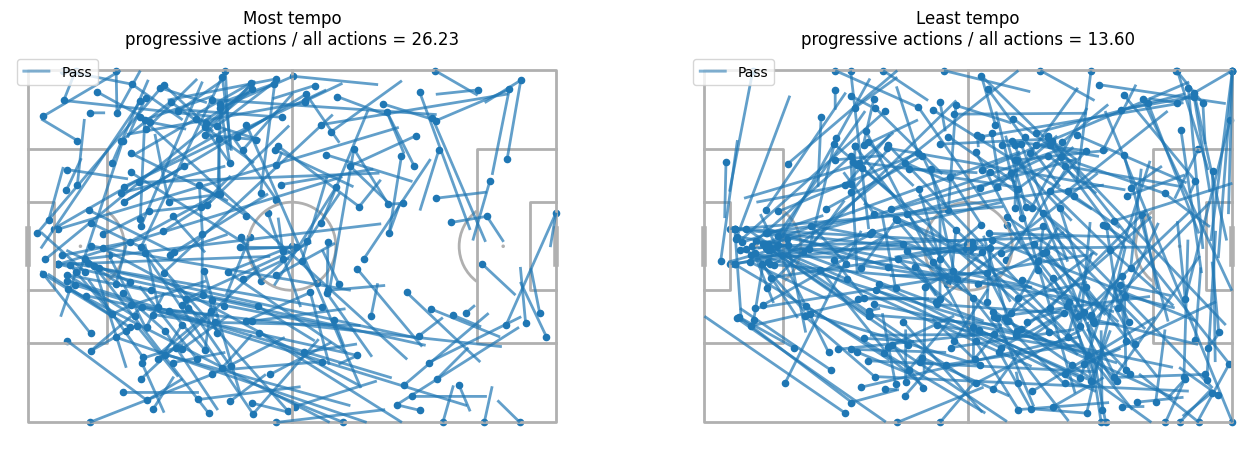

In [11]:
plot_two_matches(df, most_tempo, least_tempo)


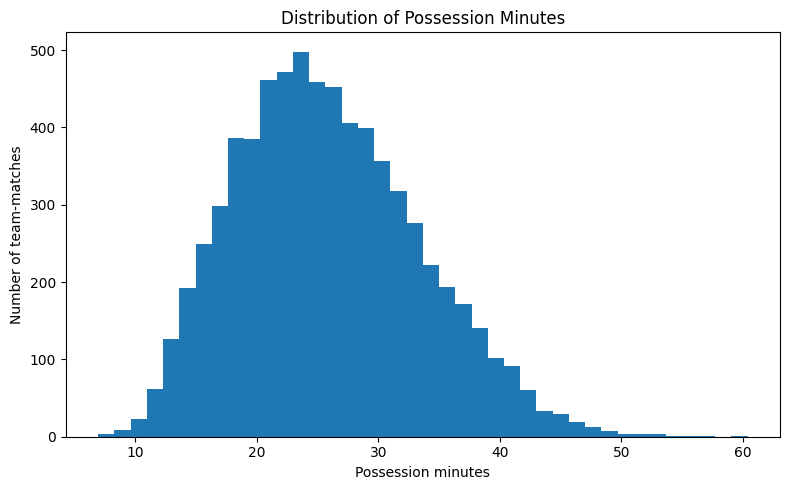

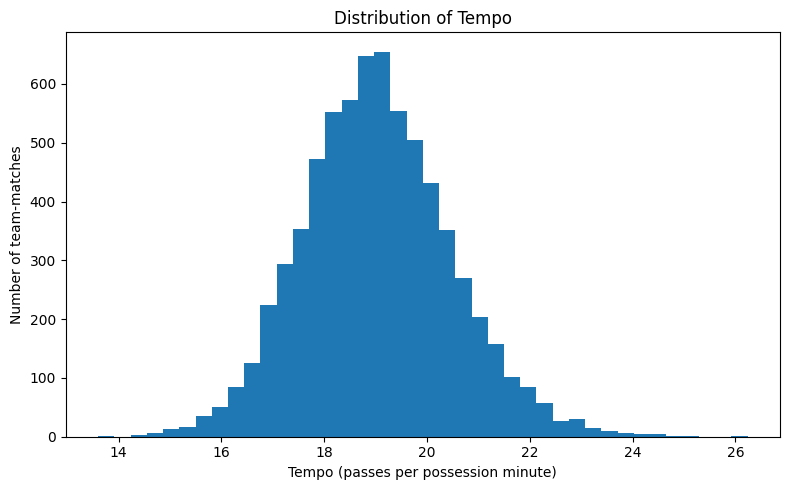

In [5]:
import matplotlib.pyplot as plt

def plot_tempo_hist(tempo_df, bins=40):
    x = tempo_df["tempo"].dropna()

    plt.figure(figsize=(8, 5))
    plt.hist(x, bins=bins)
    plt.xlabel("Tempo (passes per possession minute)")
    plt.ylabel("Number of team-matches")
    plt.title("Distribution of Tempo")
    plt.tight_layout()
    plt.show()
def plot_possession_minutes_hist(tempo_df, bins=40):
    x = tempo_df["possession_minutes"].dropna()

    plt.figure(figsize=(8, 5))
    plt.hist(x, bins=bins)
    plt.xlabel("Possession minutes")
    plt.ylabel("Number of team-matches")
    plt.title("Distribution of Possession Minutes")
    plt.tight_layout()
    plt.show()
plot_possession_minutes_hist(tempo)
plot_tempo_hist(tempo)


In [26]:
import numpy as np
import pandas as pd

def build_curve_fixed(df, match_id, team_id, max_poss_minutes=9.0):
    max_poss_seconds = max_poss_minutes * 60

    sub = df[(df["match_id"] == match_id)].copy()

    # ensure possession_team_id exists (same as your calc_possession_time)
    if "possession_team_id" not in sub.columns:
        if "possession_team" in sub.columns:
            sub["possession_team_id"] = sub["possession_team"].apply(
                lambda x: x.get("id") if isinstance(x, dict) else np.nan
            )
        else:
            raise ValueError("Need possession_team_id (or possession_team dict) in df.")

    # keep only possessions owned by this team
    sub = sub[sub["possession_team_id"] == team_id].copy()

    # time base (ms) + duration, same as your tempo possession calc
    sub["t"] = pd.to_timedelta(sub["timestamp"])
    if "duration" not in sub.columns:
        sub["duration"] = 0.0
    sub["duration"] = pd.to_numeric(sub["duration"], errors="coerce").fillna(0.0)
    sub["t_end"] = sub["t"] + pd.to_timedelta(sub["duration"], unit="s")

    # 1) possession segments (start/end per possession)
    seg = (sub.groupby(["possession"], as_index=False)
             .agg(start=("t", "min"), end=("t_end", "max")))
    seg["possession_seconds"] = (seg["end"] - seg["start"]).dt.total_seconds().clip(lower=0)

    # 2) passes per possession (only within those team-owned possessions)
    passes = sub[sub["type"] == "Pass"]
    pass_counts = (passes.groupby("possession").size()
                         .rename("n_passes")
                         .reset_index())

    seg = seg.merge(pass_counts, on="possession", how="left")
    seg["n_passes"] = seg["n_passes"].fillna(0).astype(int)

    # 3) order possessions chronologically, then accumulate time+passes together
    seg = seg.sort_values("start").reset_index(drop=True)
    seg["cum_poss_time"] = seg["possession_seconds"].cumsum()
    seg["cum_passes"] = seg["n_passes"].cumsum()

    # 4) truncate to fixed possession window
    seg = seg[seg["cum_poss_time"] <= max_poss_seconds].copy()

    # return x,y for plotting (end-of-possession points)
    return seg["cum_poss_time"].to_numpy(), seg["cum_passes"].to_numpy()


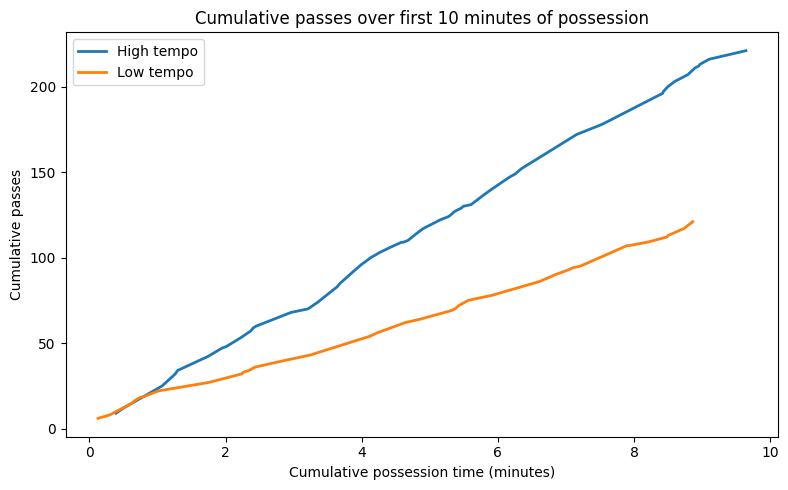

In [27]:
x_hi, y_hi = build_curve_fixed(df, most_tempo["match_id"], most_tempo["team_id"], max_poss_minutes=10.0)
x_lo, y_lo = build_curve_fixed(df, least_tempo["match_id"], least_tempo["team_id"], max_poss_minutes=10.0)

plt.figure(figsize=(8, 5))
plt.plot(x_hi / 60, y_hi, lw=2, label="High tempo")
plt.plot(x_lo / 60, y_lo, lw=2, label="Low tempo")
plt.xlabel("Cumulative possession time (minutes)")
plt.ylabel("Cumulative passes")
plt.title("Cumulative passes over first 10 minutes of possession")
plt.legend()
plt.tight_layout()
plt.show()

